In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
rng = np.random.default_rng()

%load_ext autoreload
%autoreload 2

from brain import k_cap, idx_to_vec

## Forming an assembly

### Initialize a brain area

In [1]:
from brain import RecurrentArea

n_inputs = 1000
n_neurons = 1000
cap_size = 30
density = 0.25
plasticity = 1e-1

brain_area = RecurrentArea(n_inputs, n_neurons, cap_size, density, plasticity)

In [3]:
stimulus = np.arange(cap_size)

### Form an assembly by presenting the stimulus several times

In [4]:
n_rounds = 10

activations = np.zeros((n_rounds, n_neurons))

act_csr = sparse.csr_matrix(activations)
brain_area.inhibit()
for i in range(n_rounds):
    brain_area.forward(stimulus)
    activations[i] = brain_area.read(dense=True)
    act_csr[i] = brain_area.read(dense = True)



C:\Users\aksha\anaconda3\Lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### Plot activations during formation

In [5]:
idx = activations.sum(axis=0).argsort()[::-1]
idx_csr = np.flip(act_csr.sum(axis=0).argsort())


<IPython.core.display.Javascript object>


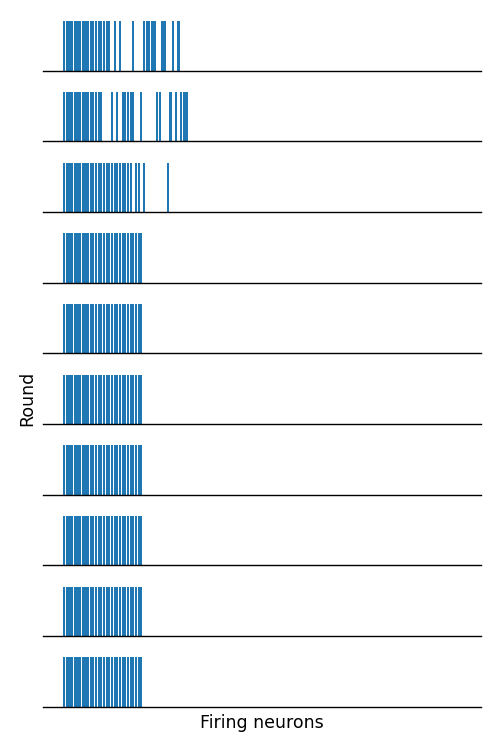

In [6]:
fig, axes = plt.subplots(n_rounds, figsize=(4, 6), sharex=True, sharey=True)

for i in range(n_rounds):
    axes[i].bar(np.arange(5*cap_size), act_csr[i, idx_csr[0, :5*cap_size]].toarray()[0])
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['left'].set_visible(False)

axes[n_rounds // 2].set_ylabel('Round')
axes[-1].set_xlabel('Firing neurons')
fig.tight_layout()



## Classifying stimulus classes

### Generate some samples from each stimulus class

In [7]:
n_classes = 3
n_samples_train = 10
n_samples_test = 200

class_vecs = np.full((n_classes, n_neurons), 1.8 * cap_size / n_neurons)
class_vecs[np.arange(n_classes)[:, np.newaxis], np.arange(n_classes * cap_size).reshape(n_classes, -1)] = 0.9

samples_train = rng.random((n_classes, n_samples_train, n_neurons)) < class_vecs[:, np.newaxis, :]
samples_test = rng.random((n_classes, n_samples_test, n_neurons)) < class_vecs[:, np.newaxis, :]



brain_area.reset()

### Visualize sample means

<IPython.core.display.Javascript object>


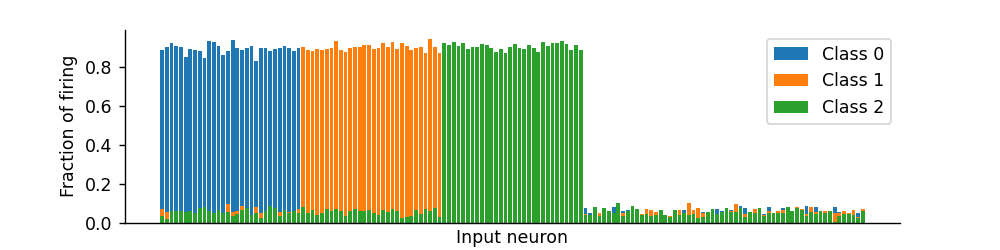

Text(0, 0.5, 'Fraction of firing')

In [8]:
fig, ax = plt.subplots(figsize=(8, 2), sharex=True, sharey=True)
for i in range(n_classes):
    ax.bar(np.arange(5 * cap_size), samples_test[i].mean(axis=0)[:5*cap_size], label='Class {}'.format(i))
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.set_xlabel('Input neuron')
ax.set_ylabel('Fraction of firing')

In [21]:
assembly_support = np.zeros((n_classes, n_neurons))
assembly_support_csr = sparse.csr_matrix(assembly_support)
for i in range(n_classes):
    brain_area.inhibit()
    for j in range(n_samples_train):
        brain_area.forward(np.nonzero(samples_train[i, j]))
    assembly_support[i] = brain_area.read(dense=True)
    assembly_support_csr[i] = brain_area.read(dense=True)



In [22]:
idx = (assembly_support_csr.T @ np.arange(n_classes, 0, -1)).argsort()[::-1] 


#print(assembly_support_csr[0, idx[:]])
#print(assembly_support[0, idx[:5 * cap_size]])

### Visualize assemblies

<IPython.core.display.Javascript object>


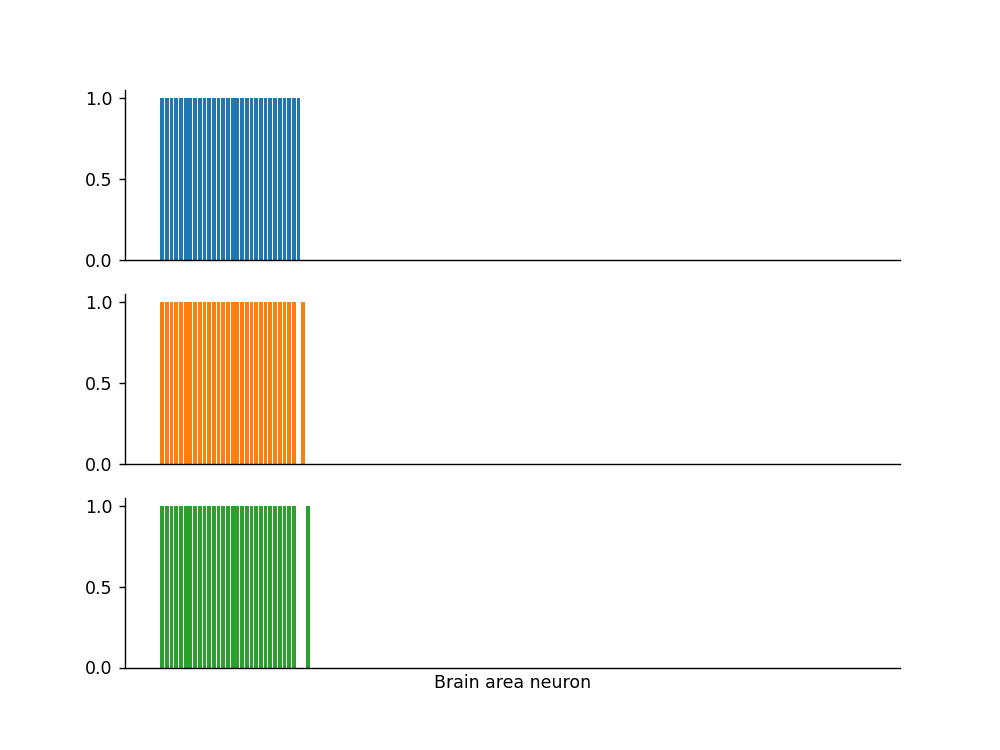

Text(0.5, 0, 'Brain area neuron')

In [23]:
fig, axes = plt.subplots(n_classes, figsize=(8, 2 * n_classes), sharex=True, sharey=True)
for i in range(n_classes):
    axes[i].bar(np.arange(5 * cap_size), assembly_support[i, idx[:5*cap_size]], label='Class {}'.format(i), color='C{}'.format(i))
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    
axes[-1].set_xlabel('Brain area neuron')


In [24]:
test_overlaps = np.zeros((n_classes, n_samples_test, n_classes))
for i in range(n_classes):
    for j in range(n_samples_test):
        brain_area.inhibit()
        brain_area.forward(np.nonzero(samples_test[i, j]), update=False)
        test_overlaps[i, j] = brain_area.read(dense=True) @ assembly_support.T


In [25]:
accuracy = np.mean(test_overlaps.argmax(axis=-1) == np.arange(n_classes)[:, np.newaxis], axis=-1)
for i in range(n_classes):
    print('Class {:d} accuracy: {:%}'.format(i, accuracy[i]))

Class 0 accuracy: 98.500000%
Class 1 accuracy: 99.500000%
Class 2 accuracy: 97.500000%


<IPython.core.display.Javascript object>


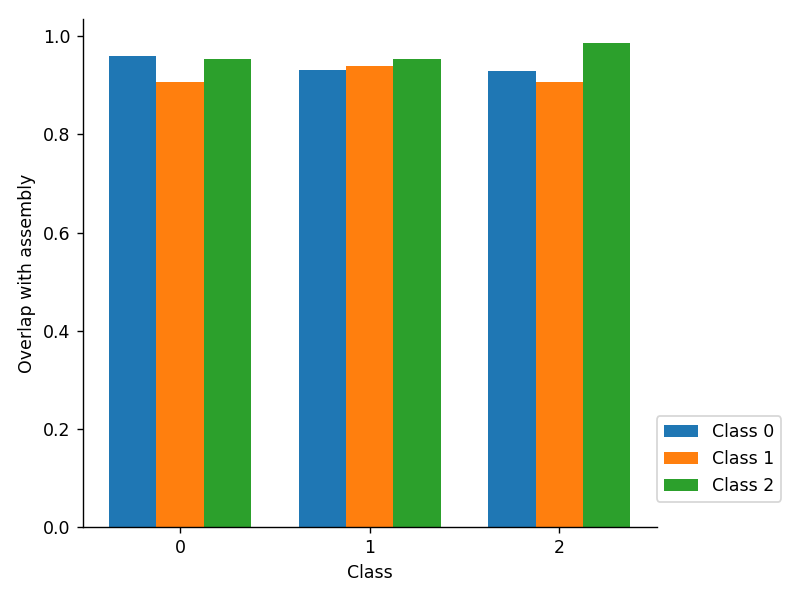

In [26]:
fig, ax = plt.subplots()
ax.bar(np.arange(n_classes)-0.25, test_overlaps[0].mean(axis=0) / cap_size, width=0.25, label='Class 0')
ax.bar(np.arange(n_classes), test_overlaps[1].mean(axis=0) / cap_size, width=0.25, label='Class 1')
ax.bar(np.arange(n_classes)+0.25, test_overlaps[2].mean(axis=0) / cap_size, width=0.25, label='Class 2')
ax.set_xticks(np.arange(n_classes))
ax.legend(loc=(1., 0.05))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Class')
ax.set_ylabel('Overlap with assembly')
fig.tight_layout()

## Memorizing sequences of inputs

### Initialize simple and scaffolded networks

In [128]:
from brain import RecurrentArea, ScaffoldNetwork

n_inputs = 1000
n_neurons = 1000
cap_size = 30
density = 0.4
plasticity = 1e-1

simple_seq_area = RecurrentArea(n_inputs, n_neurons, cap_size, density, plasticity)
scaff_seq_net = ScaffoldNetwork(n_inputs, n_neurons, cap_size, density, plasticity)

### Define a sequence of inputs

In [129]:
seq_len = 25
sequence = np.arange(seq_len * cap_size).reshape(seq_len, cap_size)
print(sequence)

[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
   18  19  20  21  22  23  24  25  26  27  28  29]
 [ 30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
   48  49  50  51  52  53  54  55  56  57  58  59]
 [ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
   78  79  80  81  82  83  84  85  86  87  88  89]
 [ 90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
  108 109 110 111 112 113 114 115 116 117 118 119]
 [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
  138 139 140 141 142 143 144 145 146 147 148 149]
 [150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
  168 169 170 171 172 173 174 175 176 177 178 179]
 [180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
  198 199 200 201 202 203 204 205 206 207 208 209]
 [210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
  228 229 230 231 232 233 234 235 236 237 238 239]


### Train the models by repeatedly presenting the sequence, testing recall after each presentation

In [133]:
n_presentations = 10

simple_seq_assemblies = np.zeros((seq_len, n_neurons))
scaff_seq_assemblies = np.zeros((seq_len, n_neurons))
simple_seq_recall = np.zeros((n_presentations, seq_len))
scaff_seq_recall = np.zeros((n_presentations, seq_len))

simple_seq_assemblies_csr = sparse.csr_matrix(simple_seq_assemblies)
scaff_seq_assemblies_csr = sparse.csr_matrix(scaff_seq_assemblies)


for j in range(n_presentations):
    simple_seq_area.inhibit()
    scaff_seq_net.inhibit()
    for i in range(seq_len):
        simple_seq_area.forward(sequence[i])
        scaff_seq_net.forward(sequence[i])
        if j == 0:
            simple_seq_assemblies_csr[i] = simple_seq_area.read(dense=True)
            scaff_seq_assemblies_csr[i] = scaff_seq_net.read(dense=True)
            
    simple_seq_area.inhibit()
    scaff_seq_net.inhibit()
    simple_seq_area.normalize()
    scaff_seq_net.normalize()
    
    
    simple_seq_area.set_input(sequence[0])
    scaff_seq_net.set_input(sequence[0])
    for i in range(seq_len):
        simple_seq_area.step(update=False)
        scaff_seq_net.step(update=False)
        
        simple_seq_recall[j, i] = (simple_seq_assemblies_csr[i] @ simple_seq_area.read(dense=True))
        scaff_seq_recall[j, i] = scaff_seq_assemblies_csr[i] @ (scaff_seq_net.read(dense=True))



### Plot the results

<IPython.core.display.Javascript object>


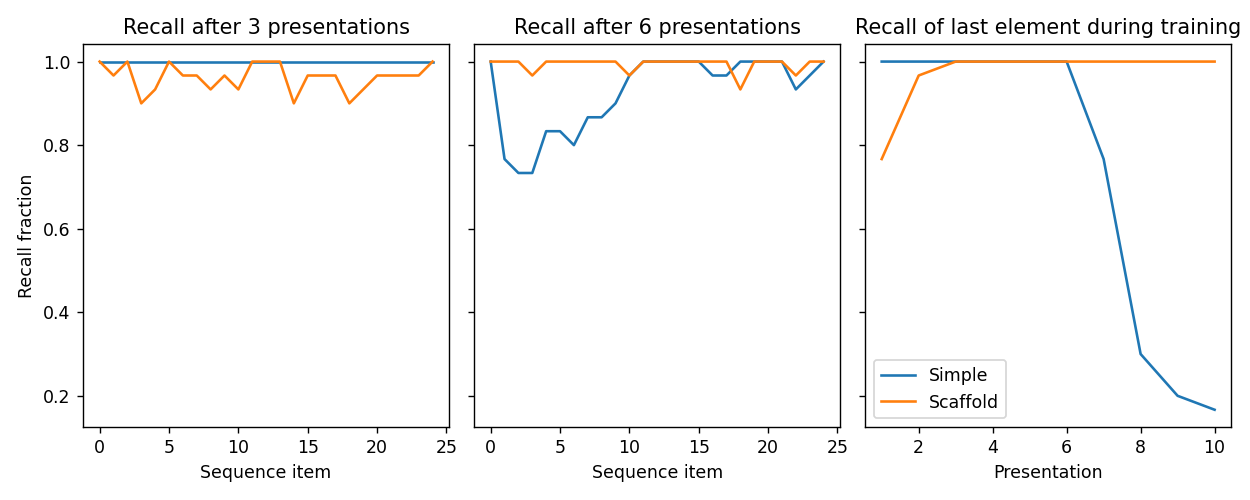

In [134]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
axes[0].plot(np.arange(seq_len), simple_seq_recall[2] / cap_size)
axes[0].plot(np.arange(seq_len), scaff_seq_recall[2] / cap_size)
axes[0].set_title('Recall after 3 presentations')
axes[0].set_ylabel('Recall fraction')
axes[0].set_xlabel('Sequence item')

axes[1].plot(np.arange(seq_len), simple_seq_recall[5] / cap_size)
axes[1].plot(np.arange(seq_len), scaff_seq_recall[5] / cap_size)
axes[1].set_title('Recall after 6 presentations')
axes[1].set_xlabel('Sequence item')

axes[2].plot(np.arange(n_presentations)+1, simple_seq_recall[:, -1] / cap_size, label='Simple')
axes[2].plot(np.arange(n_presentations)+1, scaff_seq_recall[:, -1] / cap_size, label='Scaffold')
axes[2].set_title('Recall of last element during training')
axes[2].set_xlabel('Presentation')
axes[2].legend()

fig.tight_layout()

## Simulate a FSM (DFA) to recognize numbers divisible by 3

We will simulate the following FSM, which recognizes numbers divisible by 3. It does this by tracking the sum of the digits mod 3 and accepting if the result is 0.

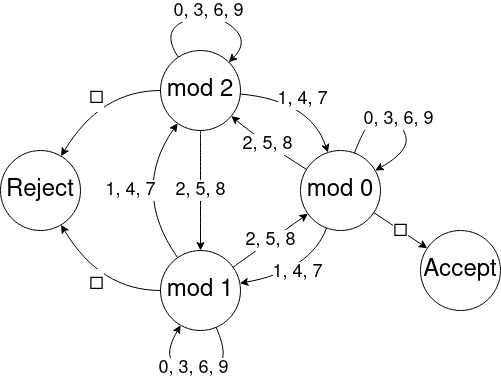

### Define the FSM (via its transitions)

In [81]:
transition_list = []

for mod in range(3):
    for digit in range(10):
        transition_list += [[mod, digit, (mod + digit) % 3]]

transition_list += [[0, 10, 3], [1, 10, 4], [2, 10, 4]]
print(transition_list)

[[0, 0, 0], [0, 1, 1], [0, 2, 2], [0, 3, 0], [0, 4, 1], [0, 5, 2], [0, 6, 0], [0, 7, 1], [0, 8, 2], [0, 9, 0], [1, 0, 1], [1, 1, 2], [1, 2, 0], [1, 3, 1], [1, 4, 2], [1, 5, 0], [1, 6, 1], [1, 7, 2], [1, 8, 0], [1, 9, 1], [2, 0, 2], [2, 1, 0], [2, 2, 1], [2, 3, 2], [2, 4, 0], [2, 5, 1], [2, 6, 2], [2, 7, 0], [2, 8, 1], [2, 9, 2], [0, 10, 3], [1, 10, 4], [2, 10, 4]]


### Define a network to simulate the FSM

In [82]:
from brain import FSMNetwork

n_symbol_neurons = 1000
n_state_neurons = 500
n_arc_neurons = 5000
cap_size = 70
density = 0.2
plasticity = 1e-1

fsm_net = FSMNetwork(n_symbol_neurons, n_state_neurons, n_arc_neurons, cap_size, density, plasticity)

n_symbols = 10 + 1
n_states = 3 + 2

symbols = np.arange(n_symbols * cap_size).reshape(n_symbols, cap_size)
states = np.arange(n_states * cap_size).reshape(n_states, cap_size)

n_arcs = 11 * 3

### Train the model by repeatedly presenting each transition

In [83]:
n_presentations = 20

arcs = np.zeros((len(transition_list), cap_size), dtype=int)
arcs_csr = sparse.csr_matrix(arcs)
for i in range(n_presentations):
    for j, transition in enumerate(transition_list):
        fsm_net.train(symbols[transition[1]], states[transition[0]], states[transition[2]])
        arcs_csr[j] = fsm_net.arc_area.read()

state_overlaps = np.zeros((len(transition_list), n_states))
state_overlaps_csr = sparse.csr_matrix(state_overlaps)
for i, transition in enumerate(transition_list):
    fsm_net.inhibit()
    fsm_net.arc_area.forward([symbols[transition[1]], states[transition[0]]], update=False)
    fsm_net.state_area.forward(fsm_net.arc_area.read(), update=False)
    state_overlaps_csr[i] = idx_to_vec(states, n_state_neurons) @ fsm_net.read(dense=True)

### Test the model by presenting a string of digits

Enter a number, for example ```30471```

In [84]:
raw = input('Enter a string of digits: ')
sequence = [int(x) for x in raw] + [10]

Enter a string of digits: 30471


In [85]:
outputs = np.zeros((len(sequence)+1, n_state_neurons))
outputs_csr = sparse.csr_matrix(outputs)
fsm_net.state_area.fire(states[0], update=False)
outputs_csr[0] = fsm_net.read(dense=True)
for i in range(len(sequence)):
    fsm_net.forward(symbols[sequence[i]], update=False)
    outputs_csr[i+1] = fsm_net.read(dense=True)

### Plot the result

  (0, 0)	1.0
  (1, 0)	1.0
  (2, 0)	1.0
  (3, 1)	1.0
  (4, 2)	1.0
  (5, 0)	1.0
  (6, 3)	1.0


<IPython.core.display.Javascript object>


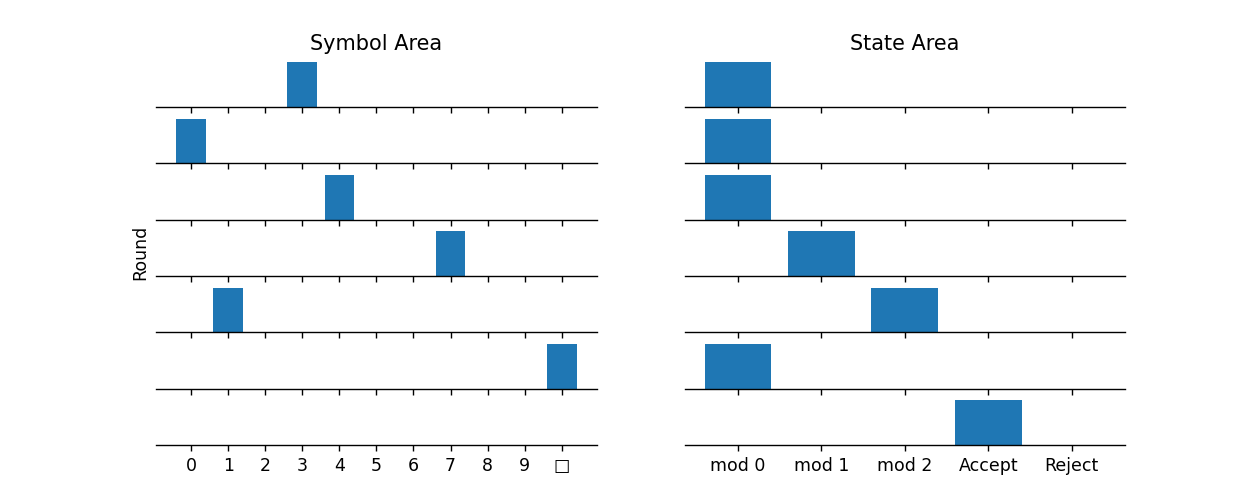

In [86]:
symbol_overlaps = (np.zeros((len(sequence)+1, n_symbols)))
symbol_overlaps[np.arange(len(sequence)), sequence] = 1.

state_overlaps = outputs_csr @ idx_to_vec(states, n_state_neurons).T / cap_size
print(sparse.csr_matrix(state_overlaps))

fig, axes = plt.subplots(len(sequence)+1, 2, figsize=(10, 4), sharey=True)
for i in range(len(sequence) + 1):
    axes[i, 0].bar(np.arange(n_symbols), symbol_overlaps[i])
    axes[i, 1].bar(np.arange(n_states), state_overlaps[i])
    axes[i, 0].set_xticks(np.arange(n_symbols))
    axes[i, 1].set_xticks(np.arange(n_states))
    
axes[-1, 0].set_xticklabels([i for i in range(n_symbols-1)] + ['□'])
axes[-1, 1].set_xticklabels(['mod 0', 'mod 1', 'mod 2', 'Accept', 'Reject'])

axes[len(sequence) // 2, 0].set_ylabel('Round')
axes[0, 0].set_title('Symbol Area')
axes[0, 1].set_title('State Area')
    
for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])

## Simulate a PFA to generate simple sentences

We will train a NEMO network to simulate the following PFA, which generates sentences like "the boy throws a ball", "a dog catches the ball", ....

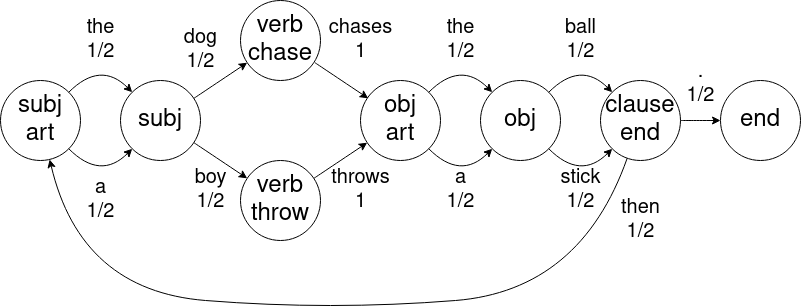

One transition out of each state is sampled uniformly at random.

### Define the PFA (via its transitions)

In [93]:
lexicon = np.array(['the', 'a', 'boy', 'dog', 'throws', 'chases', 'ball', 'stick', 'then', '.'])

#transition = [state, random_bit, new_state, output_symbol]

transition_list = [[0, 0, 1, 0], [0, 1, 1, 1], # subject article
                   [1, 0, 2, 2], [1, 1, 3, 3], # subject
                   [2, 0, 4, 4], [2, 1, 4, 4], # verb throws
                   [3, 0, 4, 5], [3, 1, 4, 5], # verb chases
                   [4, 0, 5, 0], [4, 1, 5, 1], # object article
                   [5, 0, 6, 6], [5, 1, 6, 7], # object
                   [6, 0, 7, 9], [6, 1, 0, 8]] # clause end

In [94]:
n_states = 8
n_symbols = len(lexicon)
n_arcs = len(transition_list)

### Define a network of brain areas

In [95]:
from brain import PFANetwork

n_symbol_neurons = 1000
n_state_neurons = 1000
n_arc_neurons = 5000
n_random_neurons = 1000
cap_size = 70
density = 0.25
plasticity = 0.1

pfa_net = PFANetwork(n_symbol_neurons, n_state_neurons, n_arc_neurons, n_random_neurons, cap_size, density, plasticity)

In [96]:
states = np.arange(n_states * cap_size).reshape(n_states, cap_size)
symbols = np.arange(n_symbols * cap_size).reshape(n_symbols, cap_size)

### Train the model by repeatedly presenting each transition

In [97]:
n_presentations = 20

for i in range(n_presentations):
    for j, transition in enumerate(transition_list):
        pfa_net.train(states[transition[0]], transition[1], states[transition[2]], symbols[transition[3]])

### Sample from the model

In [107]:
symbol_outputs = []
state_outputs = []

pfa_net.inhibit()
pfa_net.state_area.fire(states[0])
while True:
    pfa_net.step()
    symbol_outputs += [pfa_net.read(dense=True)]
    state_outputs += [pfa_net.state_area.read(dense=True)]
    
    if state_outputs[-1][:cap_size*n_states].reshape(n_states, cap_size).sum(axis=-1).argmax() == n_states - 1:
        break
        
symbol_outputs = (np.vstack(symbol_outputs))
state_outputs = (np.vstack(state_outputs))


In [112]:
symbol_overlaps=symbol_outputs[:, :cap_size*n_symbols].reshape(-1, n_symbols, cap_size).sum(axis=-1)
state_overlaps=state_outputs[:, :cap_size*n_states].reshape(-1, n_states, cap_size).sum(axis=-1)

symbol_overlaps_csr = sparse.csr_matrix(symbol_overlaps)
state_overlaps_csr=sparse.csr_matrix(state_overlaps)

output_symbols = lexicon[symbol_overlaps_csr.argmax(axis=-1)]

In [113]:
output_symbols

array([['the'],
       ['dog'],
       ['chases'],
       ['the'],
       ['ball'],
       ['.']], dtype='<U6')

In [114]:
print(symbol_overlaps.shape, n_symbols)

(6, 10) 10


### Plot the activations

<IPython.core.display.Javascript object>


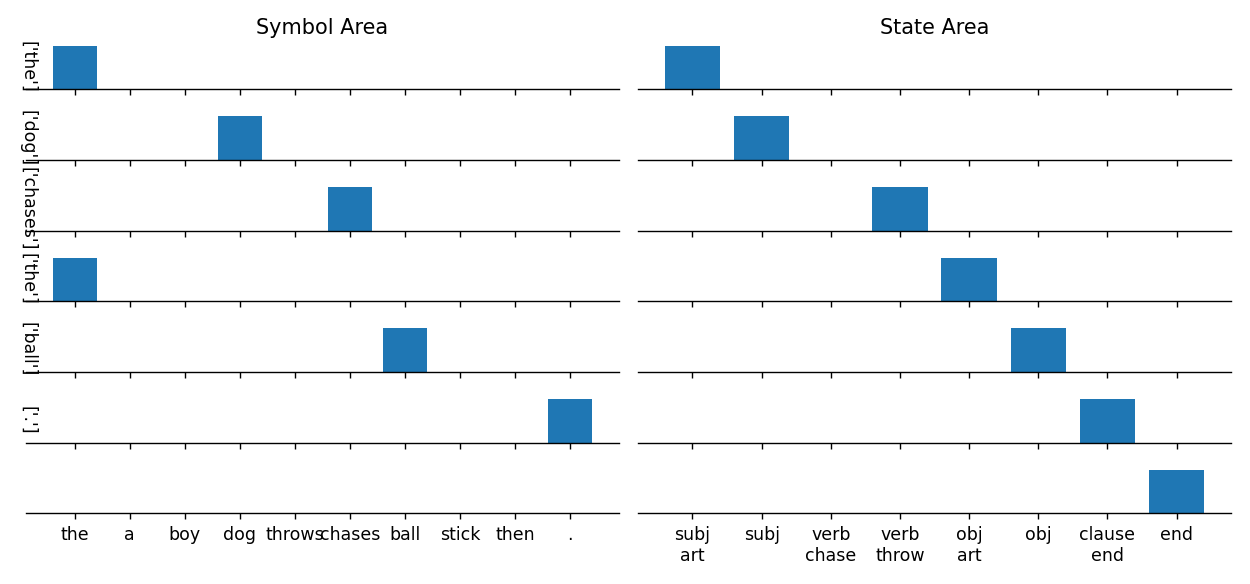

In [115]:
fig, axes = plt.subplots(len(output_symbols)+1, 2, figsize=(10, 2 * (len(output_symbols)+1) / 3), sharey=True)
axes[0, 1].bar(np.arange(n_states), [cap_size, 0, 0, 0, 0, 0, 0, 0])
axes[0, 0].set_xticks(np.arange(n_symbols))
axes[0, 1].set_xticks(np.arange(n_states))

for i in range(len(output_symbols)):
    axes[i, 0].bar(np.arange(n_symbols), symbol_overlaps[i])
    axes[i+1, 1].bar(np.arange(n_states), state_overlaps[i])
    axes[i, 0].set_xticks(np.arange(n_symbols))
    axes[i+1, 1].set_xticks(np.arange(n_states))
    
    axes[i, 0].set_ylabel(output_symbols[i], rotation=270)

axes[-1, 0].bar(np.arange(n_symbols), np.zeros(n_symbols))    
axes[-1, 0].set_xticks(np.arange(n_symbols))
    

for ax in axes:
    ax[0].set_xticklabels([])
    ax[1].set_xticklabels([])
    
axes[-1, 0].set_xticklabels(lexicon)
axes[-1, 1].set_xticklabels(['subj\nart', 'subj', 'verb\nchase', 'verb\nthrow', 'obj\nart', 'obj', 'clause\nend', 'end'])

# axes[2, 0].set_ylabel('Round')
axes[0, 0].set_title('Symbol Area')
axes[0, 1].set_title('State Area')
    
for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
    
fig.tight_layout()

## Simulate a Turing machine to recognize palindromes

First, we need to define a Turing machine which will recognize palindromes. This Turing machine will always accept strings which are empty or contain a single character. For longer strings, it will compare the first and last character of the string, reject if they do not match, and otherwise delete them both and recurse.

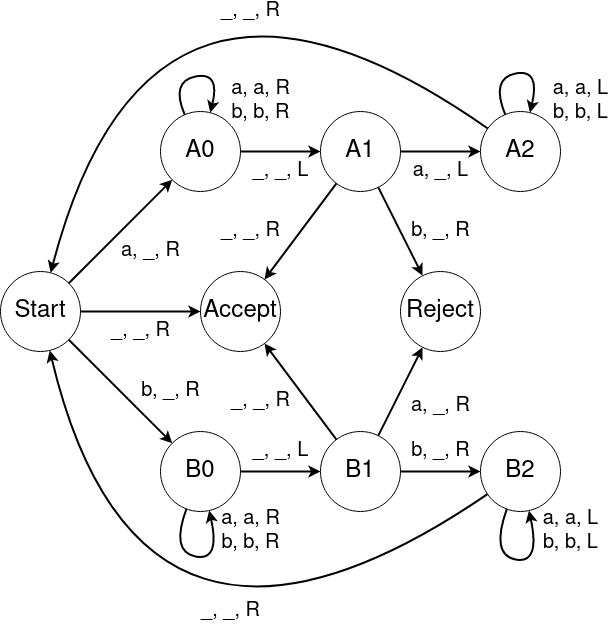

In [116]:
alphabet = 'ab'

In [117]:
n_symbols = len(alphabet) + 1
n_states = len(alphabet) * 3 + 3

In [118]:
#transition: [state, symbol, new_state, new_symbol, direction]
#direction: 0 = left, 1 = right
transition_list = [[0, 0, n_states-2, 0, 0]] + [[0, i+1, i*3+1, 0, 1] for i in range(len(alphabet))]
for i in range(len(alphabet)):
    transition_list += [[i*3+1, 0, i*3+2, 0, 0]] + [[i*3+1, j, i*3+1, j, 1] for j in range(1, n_symbols)]
    transition_list += [[i*3+2, 0, n_states-2, 0, 1]] + [[i*3+2, i+1, i*3+3, 0, 0] if j == i+1 else [i*3+2, j, n_states-1, 0, 0] for j in range(1, n_symbols)]
    transition_list += [[i*3+3, 0, 0, 0, 1]] + [[i*3+3, j, i*3+3, j, 0] for j in range(1, n_symbols)]
transition_list += [[n_states - 2, j, n_states - 2, j, 0] for j in range(n_symbols)]
transition_list += [[n_states - 1, j, n_states - 1, j, 0] for j in range(n_symbols)]

In [119]:
from brain import TuringHeadNetwork

cap_size = 50
n_symbol_neurons = n_symbols * cap_size
n_state_neurons = n_states * cap_size
n_move_neurons = 2 * cap_size
n_arc_neurons = 3 * n_symbols * n_states * cap_size
density = 0.25
plasticity = 0.1

turing_head = TuringHeadNetwork(n_symbol_neurons, n_state_neurons, n_arc_neurons, n_move_neurons, cap_size, density, plasticity)

In [120]:
symbol_assemblies = np.arange(n_symbols * cap_size).reshape(n_symbols, cap_size)
state_assemblies = np.arange(n_states * cap_size).reshape(n_states, cap_size)
direction_assemblies = np.arange(2 * cap_size).reshape(2, cap_size)



In [ ]:
n_presentations = 30

for i in range(n_presentations):
    for j, t in enumerate(transition_list):
        turing_head.train(state_assemblies[t[0]], symbol_assemblies[t[1]], state_assemblies[t[2]], symbol_assemblies[t[3]], direction_assemblies[t[4]])

In [61]:
string = input('Enter a string from the alphabet: ')

KeyboardInterrupt: Interrupted by user

In [193]:
from brain import ExternalTape

ext_tape = ExternalTape([alphabet.index(c)+1 for c in string])

n_rounds = len(string) ** 2 + 1
state_activations = np.zeros((n_rounds+1, n_state_neurons))
symbol_activations = np.zeros((n_rounds, n_symbol_neurons))
move_activations = np.zeros((n_rounds, n_move_neurons))

state_activations_csr = sparse.csr_matrix(state_activations)
symbol_activations_csr = sparse.csr_matrix(symbol_activations)
move_activations_csr = sparse.csr_matrix(move_activations)

tapes = [ext_tape.dump()]
positions = [ext_tape.position]

turing_head.inhibit()
turing_head.state_area.fire(state_assemblies[0])
state_activations_csr[0] = turing_head.state_area.read(dense=True)
for i in range(n_rounds):
    turing_head.forward(symbol_assemblies[ext_tape.read()], update=False)
    
    state_activations[i+1] = turing_head.state_area.read(dense=True)
    symbol_activations[i] = turing_head.write_area.read(dense=True)
    move_activations[i] = turing_head.move_area.read(dense=True)
    
    state_activations_csr[i+1] = turing_head.state_area.read(dense=True)
    symbol_activations_csr[i] = turing_head.write_area.read(dense=True)
    move_activations_csr[i] = turing_head.move_area.read(dense=True)
    
    new_symbol = symbol_activations[i, :n_symbols*cap_size].reshape(n_symbols, cap_size).sum(axis=-1).argmax()
    direction = move_activations[i, :2*cap_size].reshape(2, cap_size).sum(axis=-1).argmax() * 2 - 1
    
    ext_tape.write(new_symbol)
    ext_tape.move(direction)
    tapes += [ext_tape.dump()]
    positions += [ext_tape.position]

print(state_activations_csr)

  (0, 0)	1.0
  (0, 1)	1.0
  (0, 2)	1.0
  (0, 3)	1.0
  (0, 4)	1.0
  (0, 5)	1.0
  (0, 6)	1.0
  (0, 7)	1.0
  (0, 8)	1.0
  (0, 9)	1.0
  (0, 10)	1.0
  (0, 11)	1.0
  (0, 12)	1.0
  (0, 13)	1.0
  (0, 14)	1.0
  (0, 15)	1.0
  (0, 16)	1.0
  (0, 17)	1.0
  (0, 18)	1.0
  (0, 19)	1.0
  (0, 20)	1.0
  (0, 21)	1.0
  (0, 22)	1.0
  (0, 23)	1.0
  (0, 24)	1.0
  :	:
  (17, 425)	0.0
  (17, 426)	0.0
  (17, 427)	0.0
  (17, 428)	0.0
  (17, 429)	0.0
  (17, 430)	0.0
  (17, 431)	0.0
  (17, 432)	0.0
  (17, 433)	0.0
  (17, 434)	0.0
  (17, 435)	0.0
  (17, 436)	0.0
  (17, 437)	0.0
  (17, 438)	0.0
  (17, 439)	0.0
  (17, 440)	0.0
  (17, 441)	0.0
  (17, 442)	0.0
  (17, 443)	0.0
  (17, 444)	0.0
  (17, 445)	0.0
  (17, 446)	0.0
  (17, 447)	0.0
  (17, 448)	0.0
  (17, 449)	0.0


In [194]:
state_overlaps = state_activations[:, :n_states*cap_size].reshape(n_rounds+1, n_states, cap_size).sum(axis=-1)
symbol_overlaps = symbol_activations[:, :n_symbols*cap_size].reshape(n_rounds, n_symbols, cap_size).sum(axis=-1)

<IPython.core.display.Javascript object>


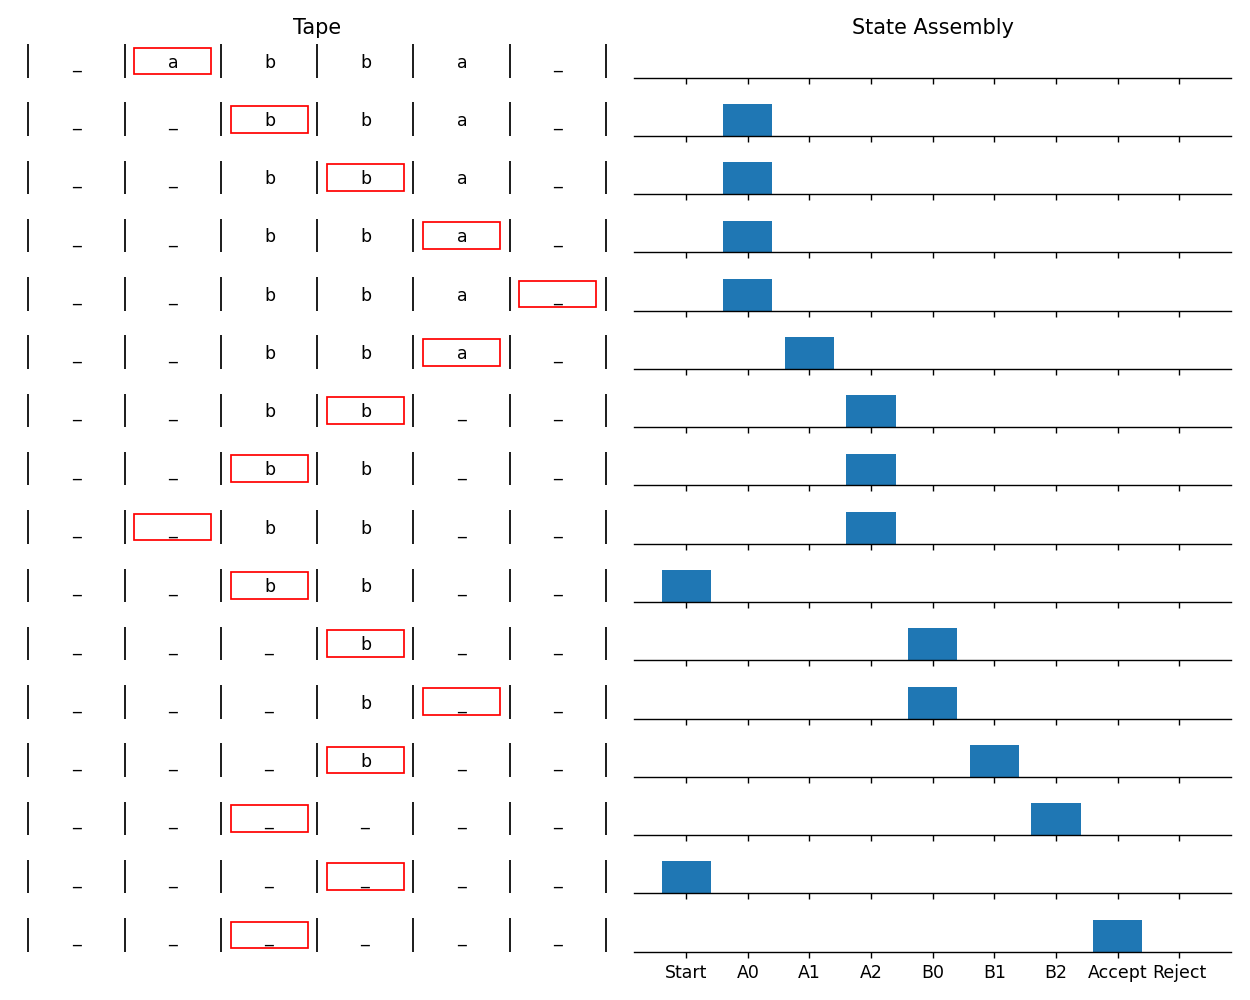

In [195]:
last_round = np.nonzero(state_overlaps.argmax(axis=-1) >= n_states-2)[0].min()+1

fig, axes = plt.subplots(last_round, 2, figsize=(10, last_round / 2))

def draw_tape(ax, tape, pos):
    ax.set_axis_off()
    for i in range(len(tape)):
        ax.text(i+0.45, 0.3, ('_' + alphabet)[tape[i]])
    ax.vlines(np.arange(len(tape)+1), 0, 1., color='black', linewidths=1)
    ax.set_xlim([-0.1, len(tape)+0.1])
    ax.set_ylim([0, 1])
    ax.add_patch(plt.Rectangle((pos+0.1, 0.1), 0.8, 0.8, fc='none', ec='red'))
    
for i in range(last_round):
    draw_tape(axes[i, 0], tapes[i][:len(string)+2], positions[i])
    axes[i, 1].bar(np.arange(n_states), state_overlaps[i])
    
    axes[i, 1].spines['top'].set_visible(False)
    axes[i, 1].spines['right'].set_visible(False)
    axes[i, 1].spines['left'].set_visible(False)
    axes[i, 1].set_xticks(np.arange(n_states))
    axes[i, 1].set_xticklabels([])
    axes[i, 1].set_yticks([])
    
axes[0, 0].set_title('Tape')
axes[0, 1].set_title('State Assembly')
    
axes[-1, 1].set_xticklabels(['Start', 'A0', 'A1', 'A2', 'B0', 'B1', 'B2', 'Accept', 'Reject'])

fig.tight_layout()